In [224]:
#!pip install rapidfuzz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helper as h
import helper_preprocessing as hp
import importlib
from sklearn.preprocessing import LabelEncoder

importlib.reload(h)

<module 'helper' from '/content/helper.py'>

# Feature exploring and Model Selection



In this notebook we will explore feature selection and creation in the data set of the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition. We alredy performed preprocessing on the data set by dealing with missing values and inconsistenices. The notebook for preprocessing is [here](https://github.com/Jsrodrigue/House-Prices---Advanced-Regression-Techniques/blob/main/notebooks/house_prices_preprocessing.ipynb).

In [225]:
# First we load the preprocessed train data

path_train = 'train_pre.csv'
df= pd.read_csv(path_train, keep_default_na=False)


# Get predictors and target
X = df.copy()
y = X.pop("SalePrice")


# Select numerical and categorical features
num_cols_all = list(X.select_dtypes(include=["int64", "float64"]).columns)
cat_cols_all = list(X.select_dtypes(include=["object", "category"]).columns)


# Define X_label
X_label = X.copy()
encoders = {}
for col in cat_cols_all:
    le = LabelEncoder()
    X_label[col] = le.fit_transform(X_label[col].astype(str))  # asegúrate de que sea string
    encoders[col] = le



## Linear regression baseline

Now lets train and compute the errors of linear regression baselines using onehot encoding and ordinal encoding, with linear o lasso regressor. We apply logaritmic scale to the features with high outliers.




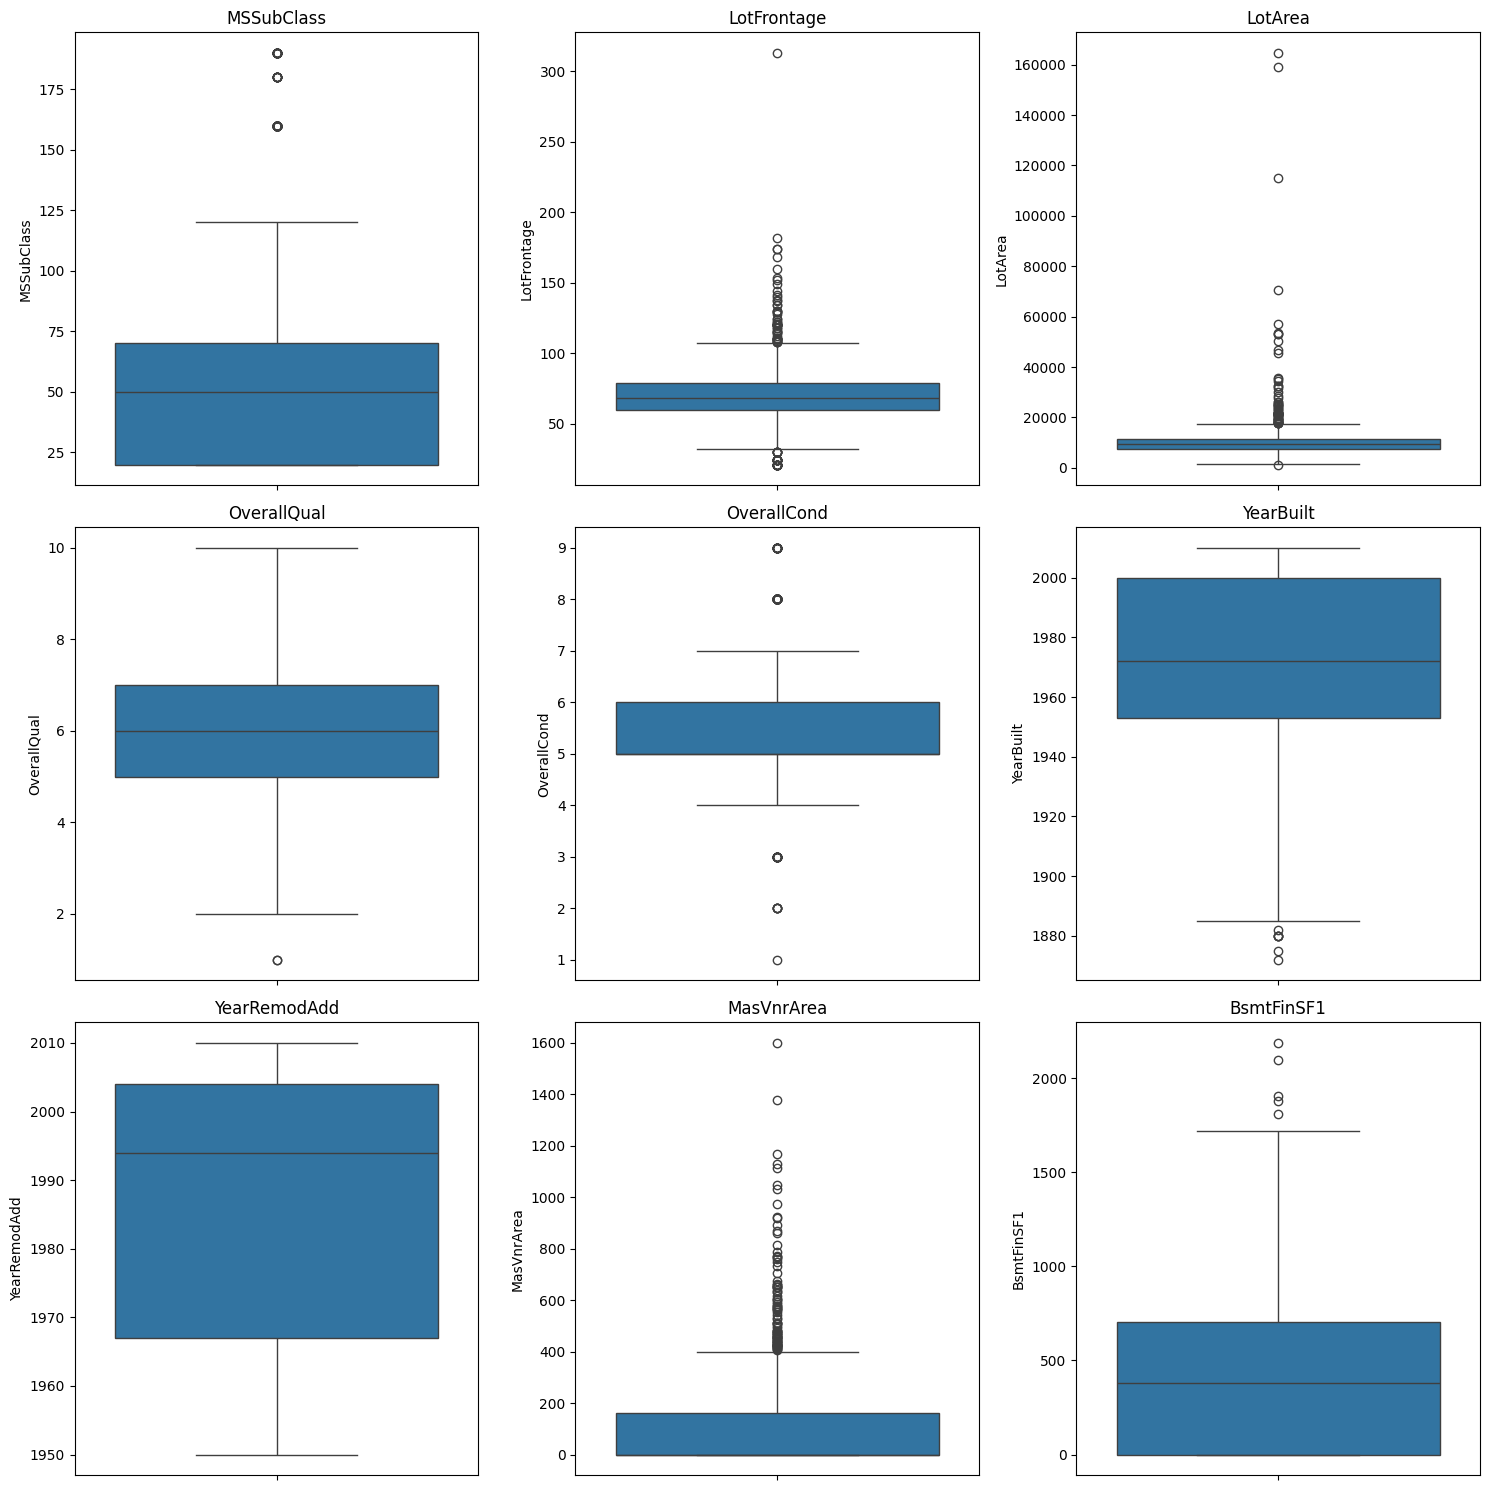

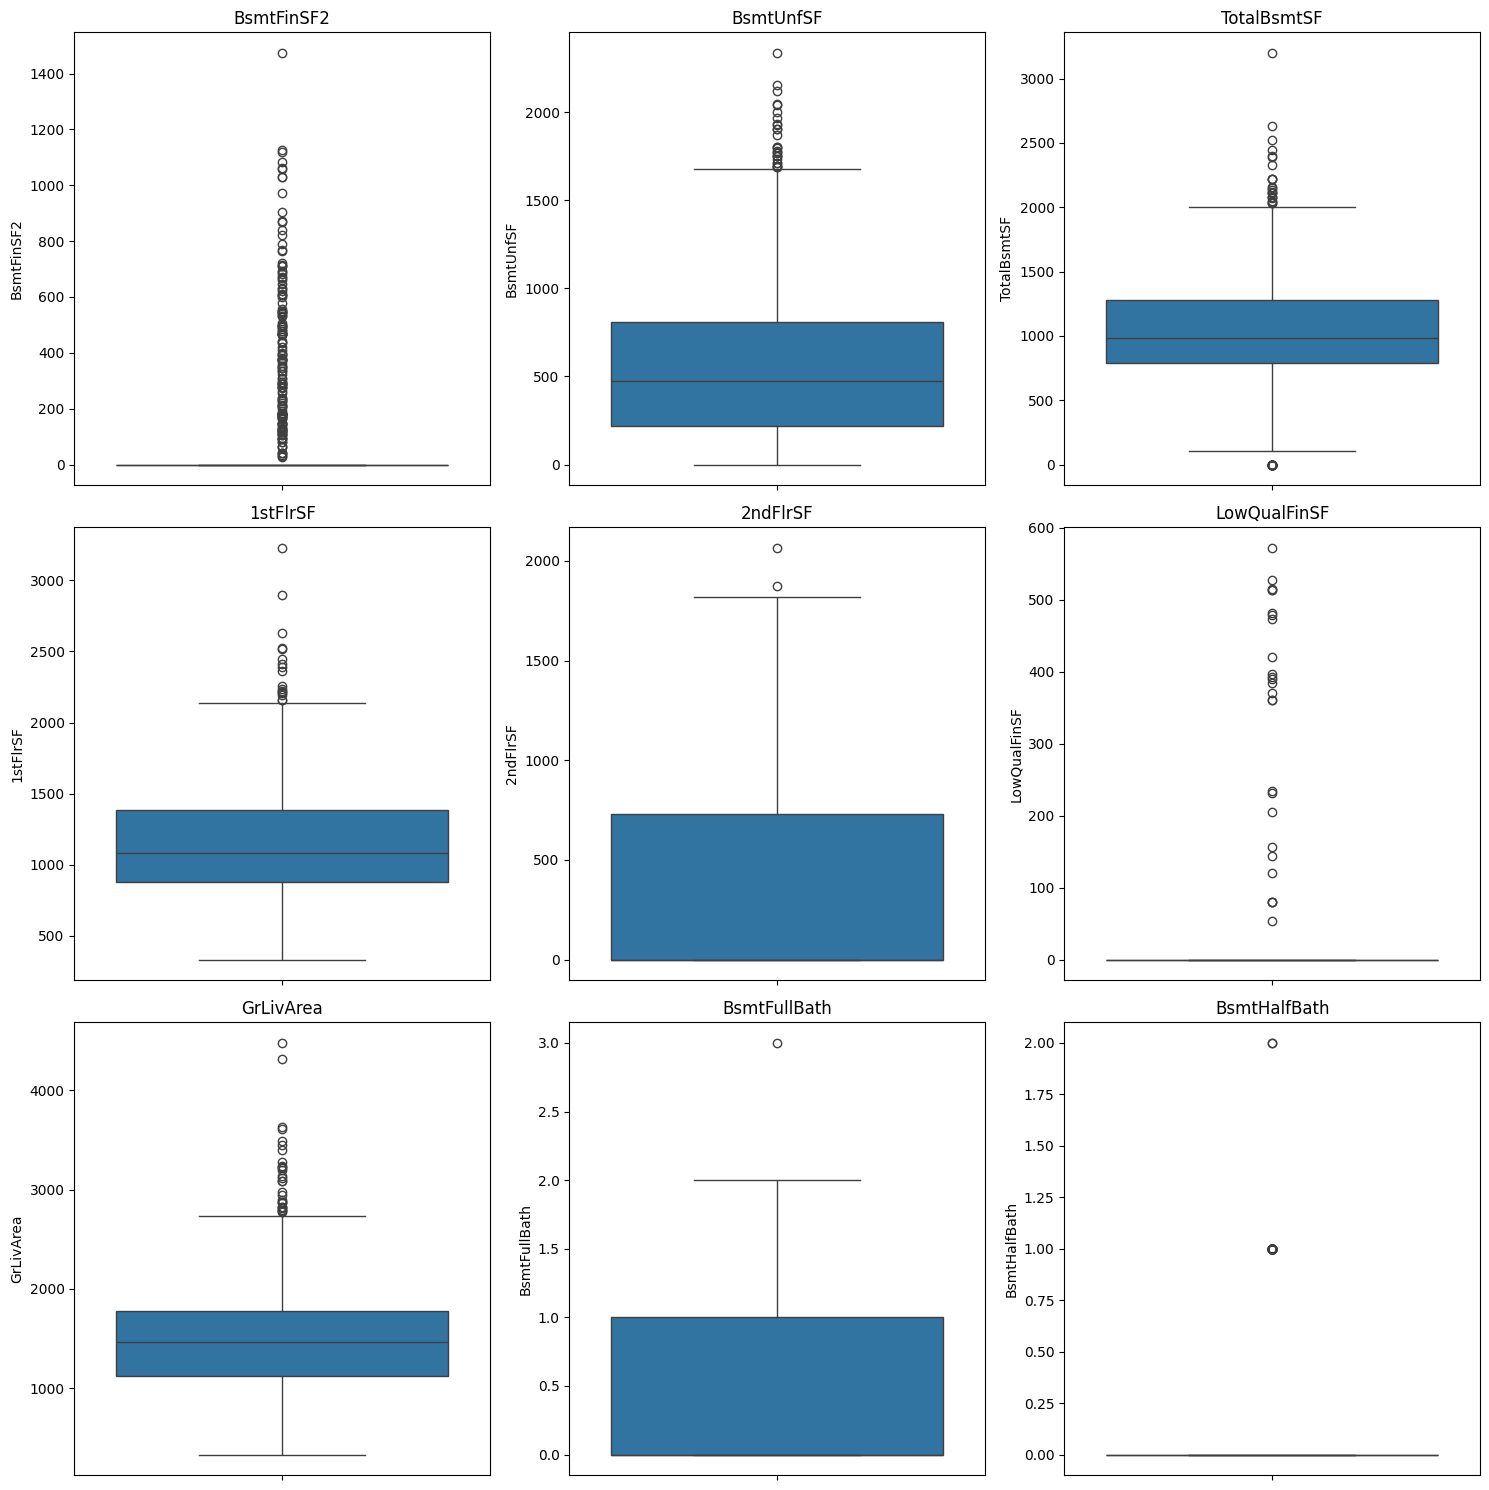

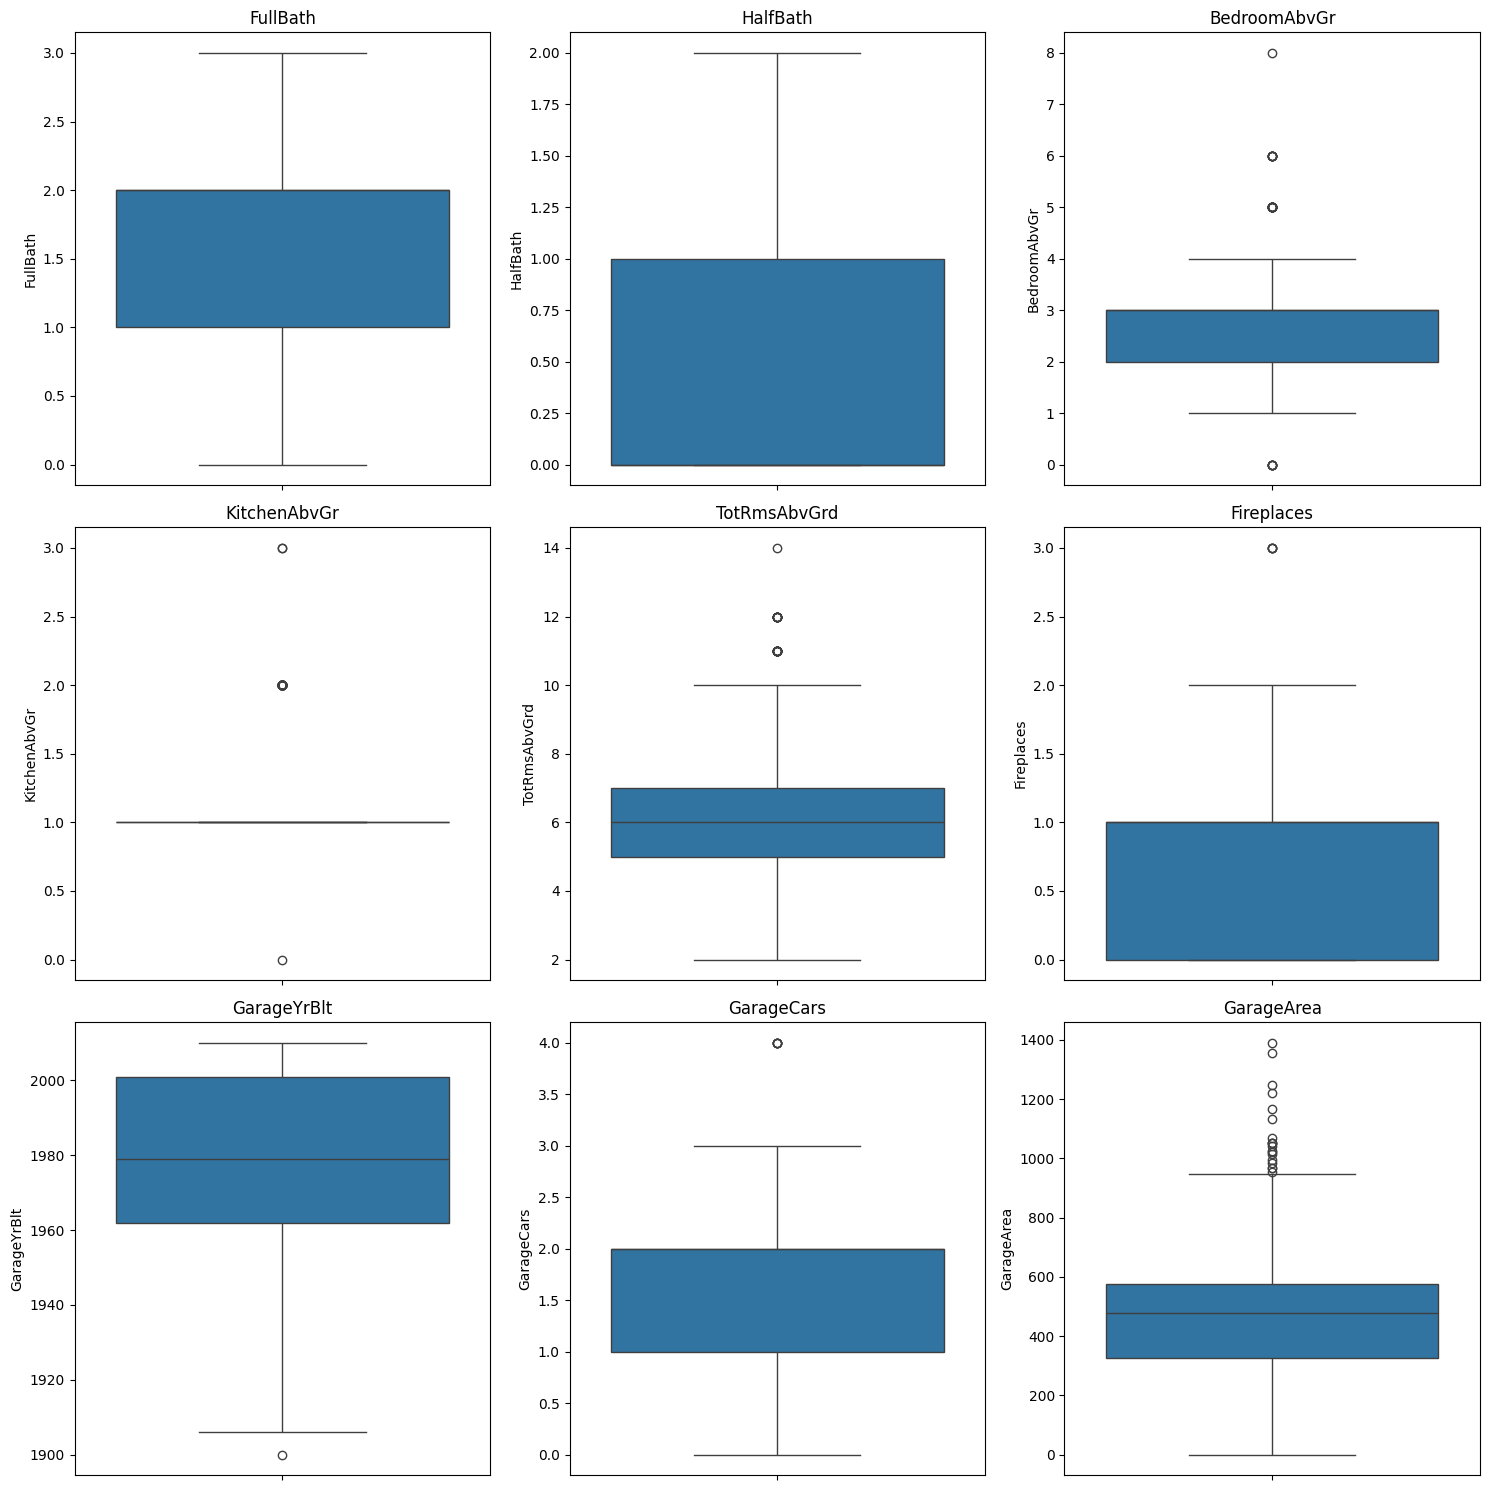

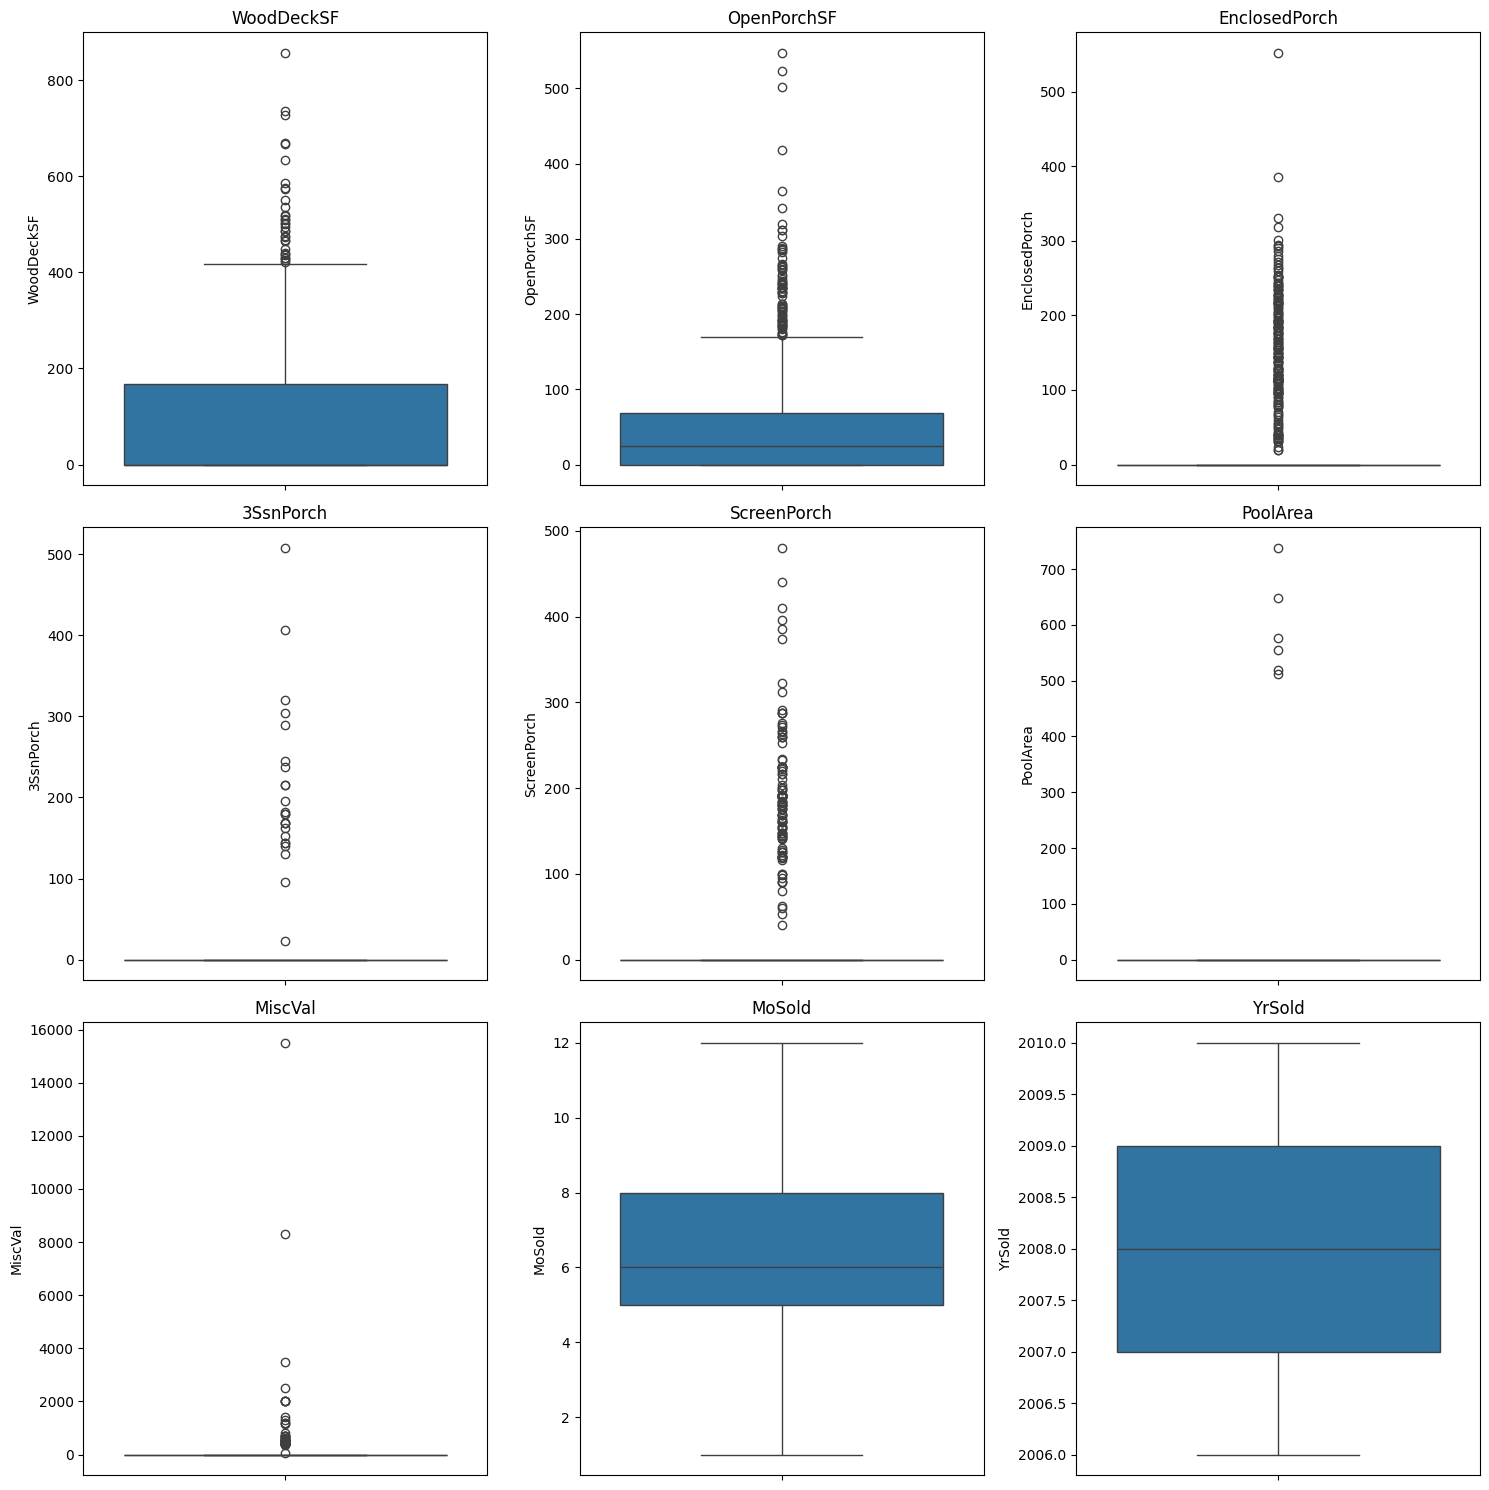

In [226]:
hp.plot_boxplots(X)


We will apply logaritmic transformation for the columns with big outliers. We identify the following columns.

In [227]:
cols_log_all=['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',  'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea',
              'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

Let's see how is the performance of Linear, Ridge, Lasso and Elastic Net models. Let's inspect several values for alpha, using the evaluate_all_linear function on the helper.py module. In this function the default value for li in elastic net is 0.5.


In [228]:
alphas =[0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100]
for alpha in alphas:
  print(f'alpha = {alpha}')
  h.evaluate_all_linear(X ,y, numeric_columns=num_cols_all, categorical_columns=cat_cols_all, log_columns=cols_log_all, alpha=alpha)
  print()

alpha = 0.0001
Linear:           MAE: 14584.172335532248 | RMSLE: 0.12020005228355607
Lasso:            MAE: 14367.345413799017 | RMSLE: 0.11831299910241658
Ridge:            MAE: 14584.153129640305 | RMSLE: 0.12020005228355607
elastic_net:      MAE: 14434.091045588622 | RMSLE: 0.12020005228355607

alpha = 0.001
Linear:           MAE: 14584.172335532248 | RMSLE: 0.12020005228355607
Lasso:            MAE: 14171.871621704966 | RMSLE: 0.11638104950818973
Ridge:            MAE: 14583.980472563973 | RMSLE: 0.12020005228355607
elastic_net:      MAE: 14148.990417073295 | RMSLE: 0.12020005228355607

alpha = 0.01
Linear:           MAE: 14584.172335532248 | RMSLE: 0.12020005228355607
Lasso:            MAE: 16988.22936376541 | RMSLE: 0.13176600277872771
Ridge:            MAE: 14582.27299799195 | RMSLE: 0.12020005228355607
elastic_net:      MAE: 15974.339115303372 | RMSLE: 0.12020005228355607

alpha = 0.1
Linear:           MAE: 14584.172335532248 | RMSLE: 0.12020005228355607
Lasso:            MAE:

We see that the best models is Lasso with alpha=0.001, which gives a RMSLE of 0.11638104950818973. This is expected, as Lasso performs feature selection.

# FEATURE SELECTION AND CREATION

In [229]:
# Product tuples
product_tuples = [
    ('GrLivArea', 'OverallQual'),
    ('TotalBsmtSF', 'OverallQual'),
    ('1stFlrSF', '2ndFlrSF'),
    ('WoodDeckSF', 'OpenPorchSF'),
    ('OpenPorchSF', 'ScreenPorch'),
    ('EnclosedPorch', '3SsnPorch'),
    ('FullBath', 'GarageCars'),
    ('BsmtFullBath', 'FullBath')
]

# Ratio tuples
ratio_tuples = [
    ('GrLivArea', 'TotalBsmtSF'),
    ('1stFlrSF', '2ndFlrSF'),
    ('OpenPorchSF', 'EnclosedPorch'),
    ('WoodDeckSF', 'ScreenPorch'),
    ('FullBath', 'HalfBath'),
    ('BsmtFullBath', 'FullBath')
]

In [230]:
X_interac, num_cols_interac = h.add_interactions(X, product_tuples=product_tuples, ratio_tuples=ratio_tuples)

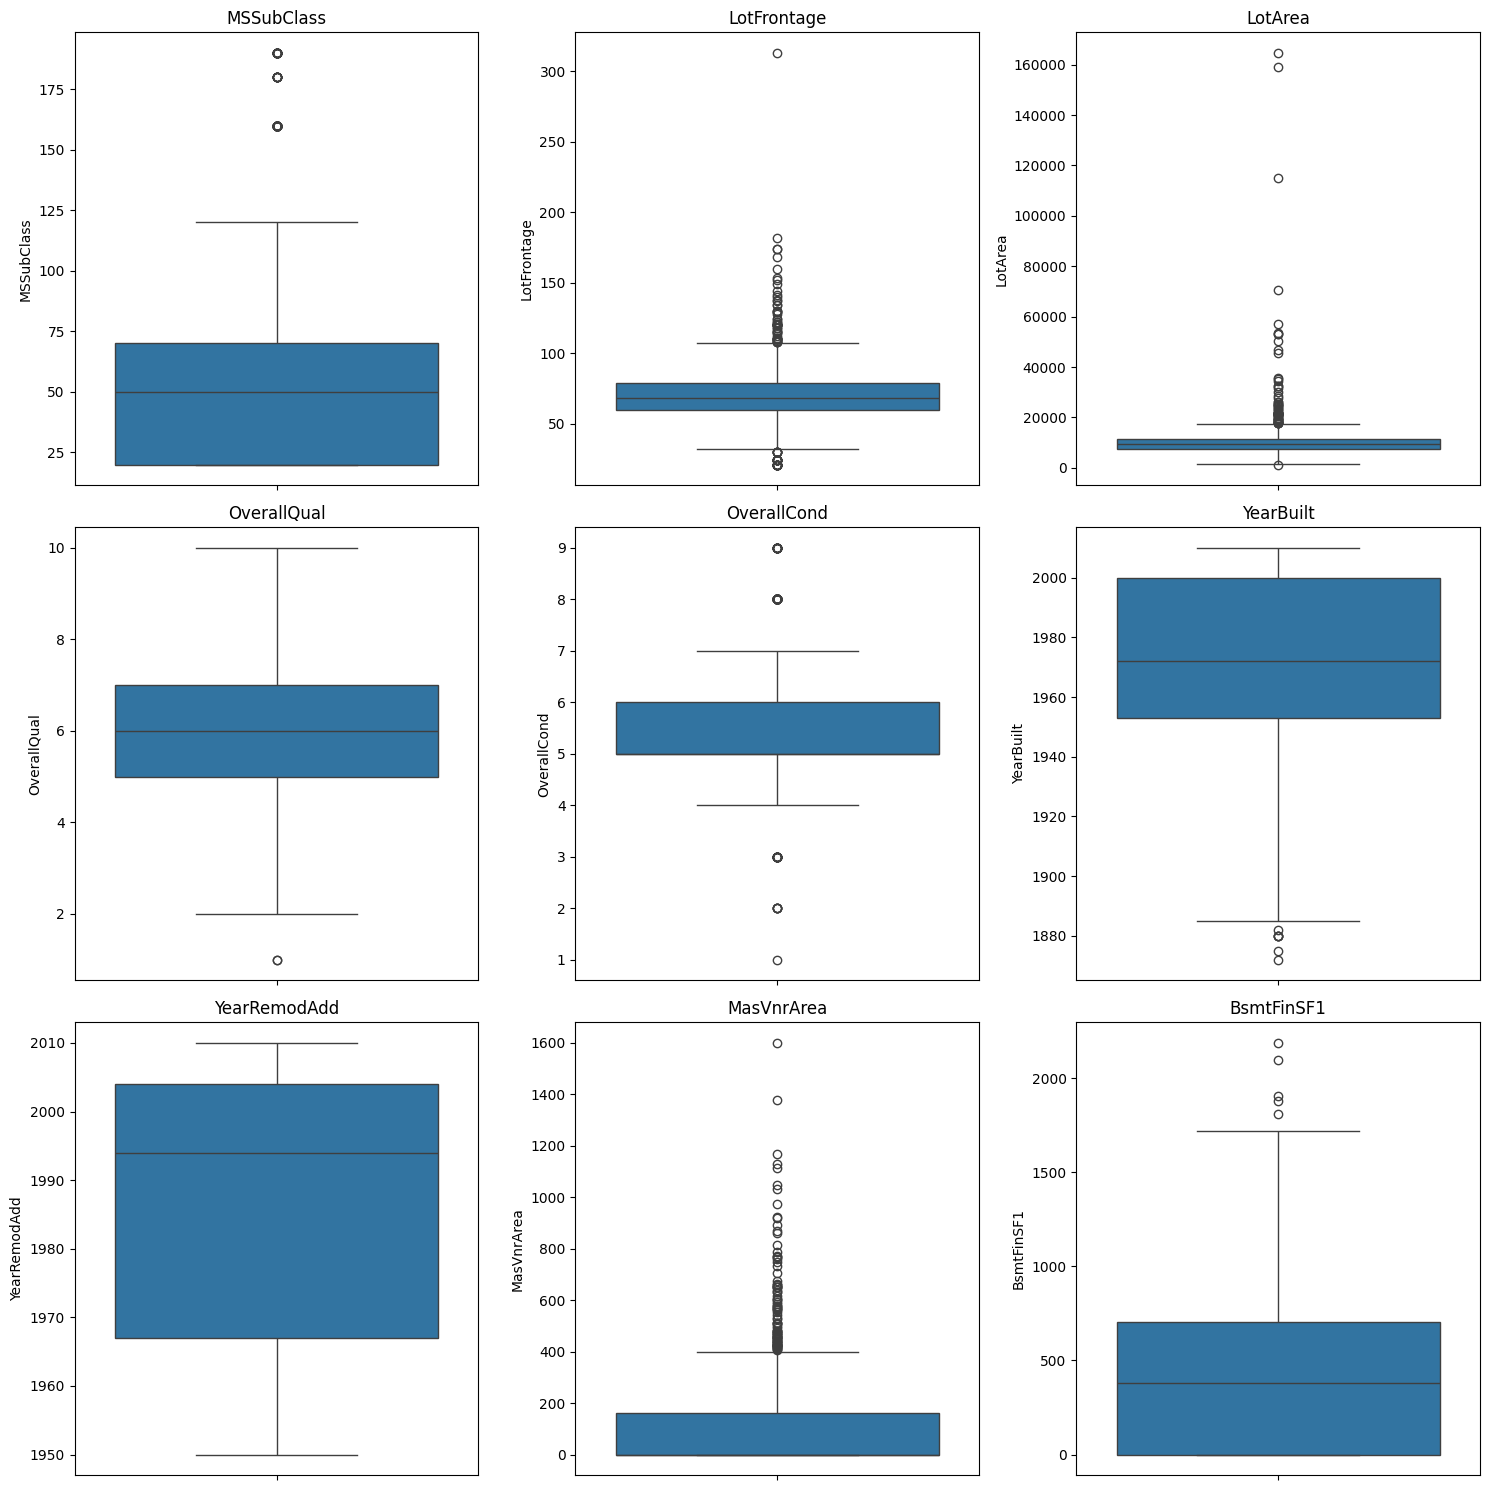

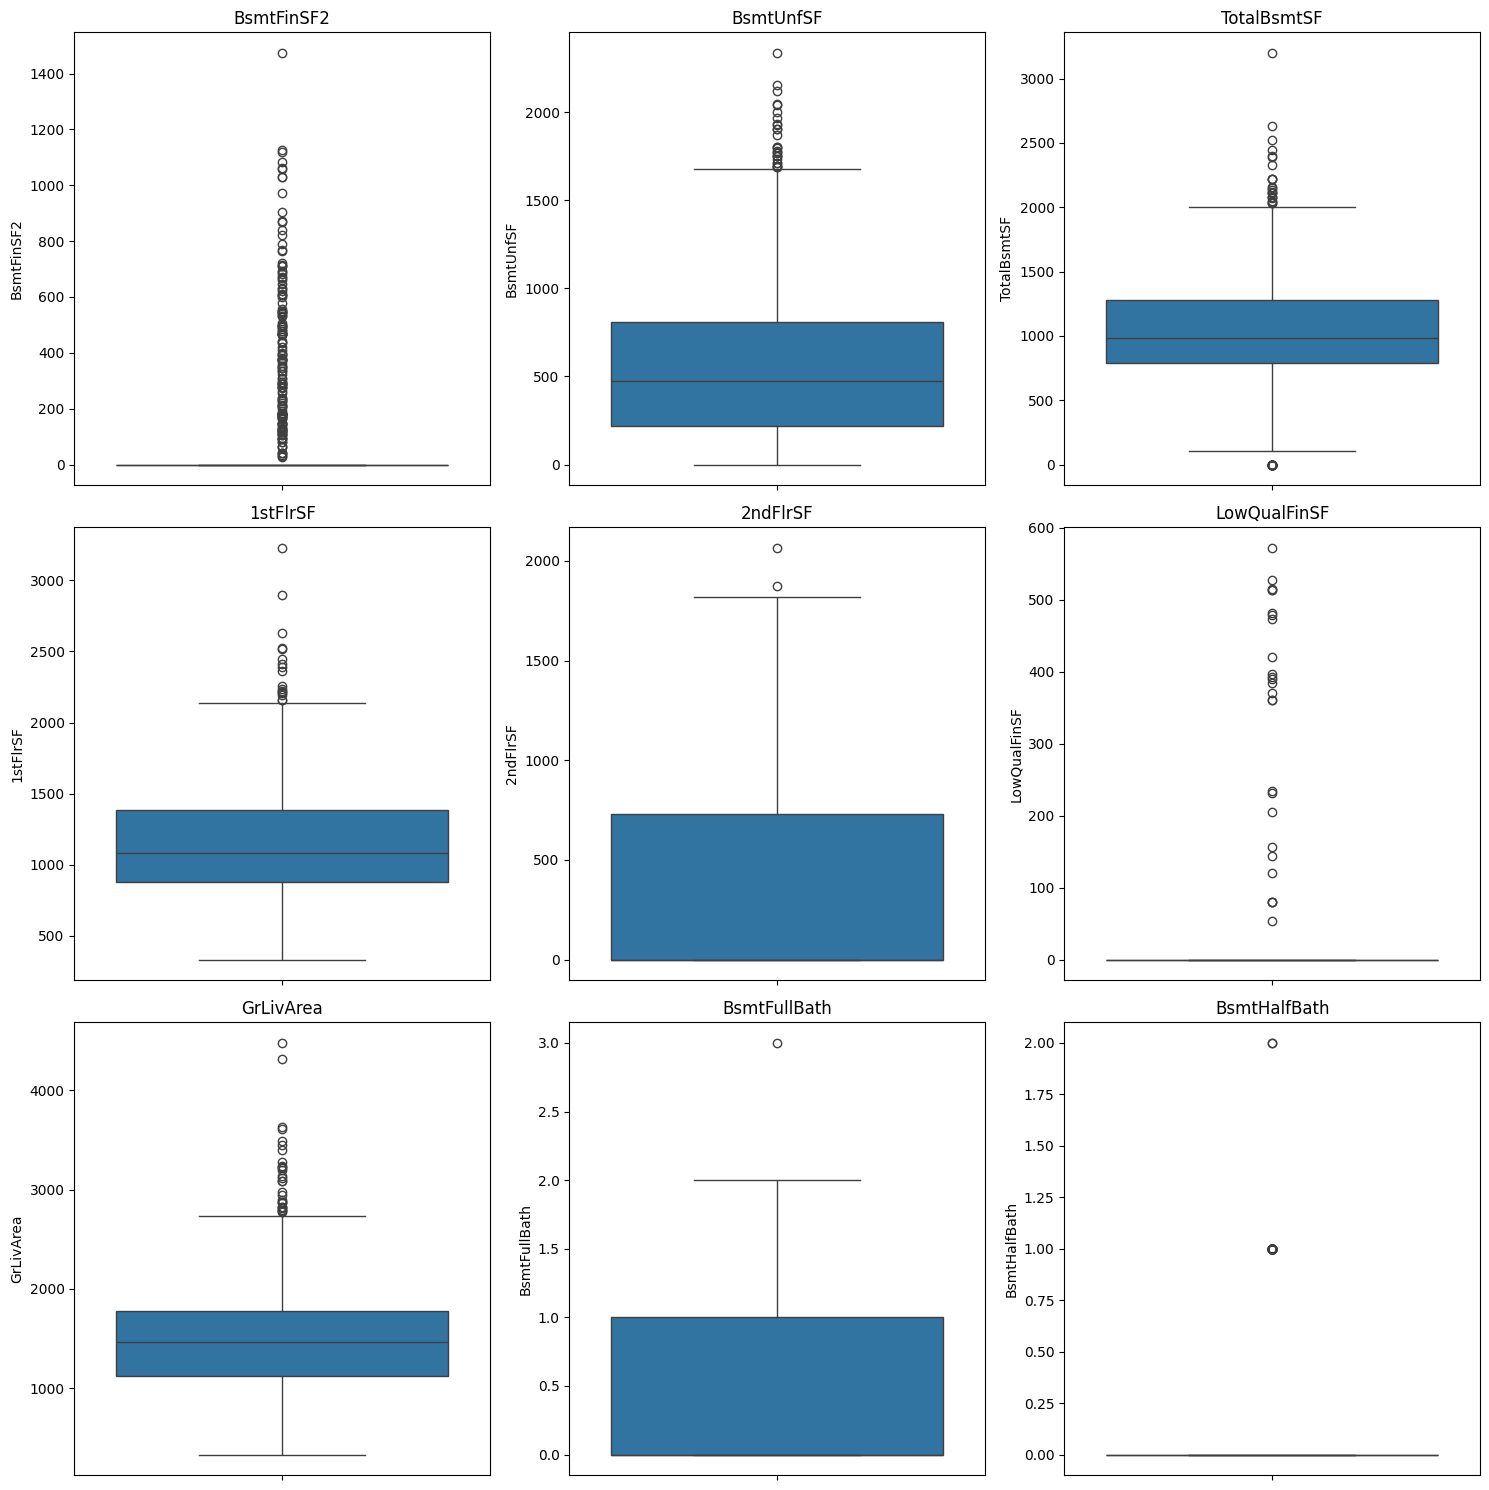

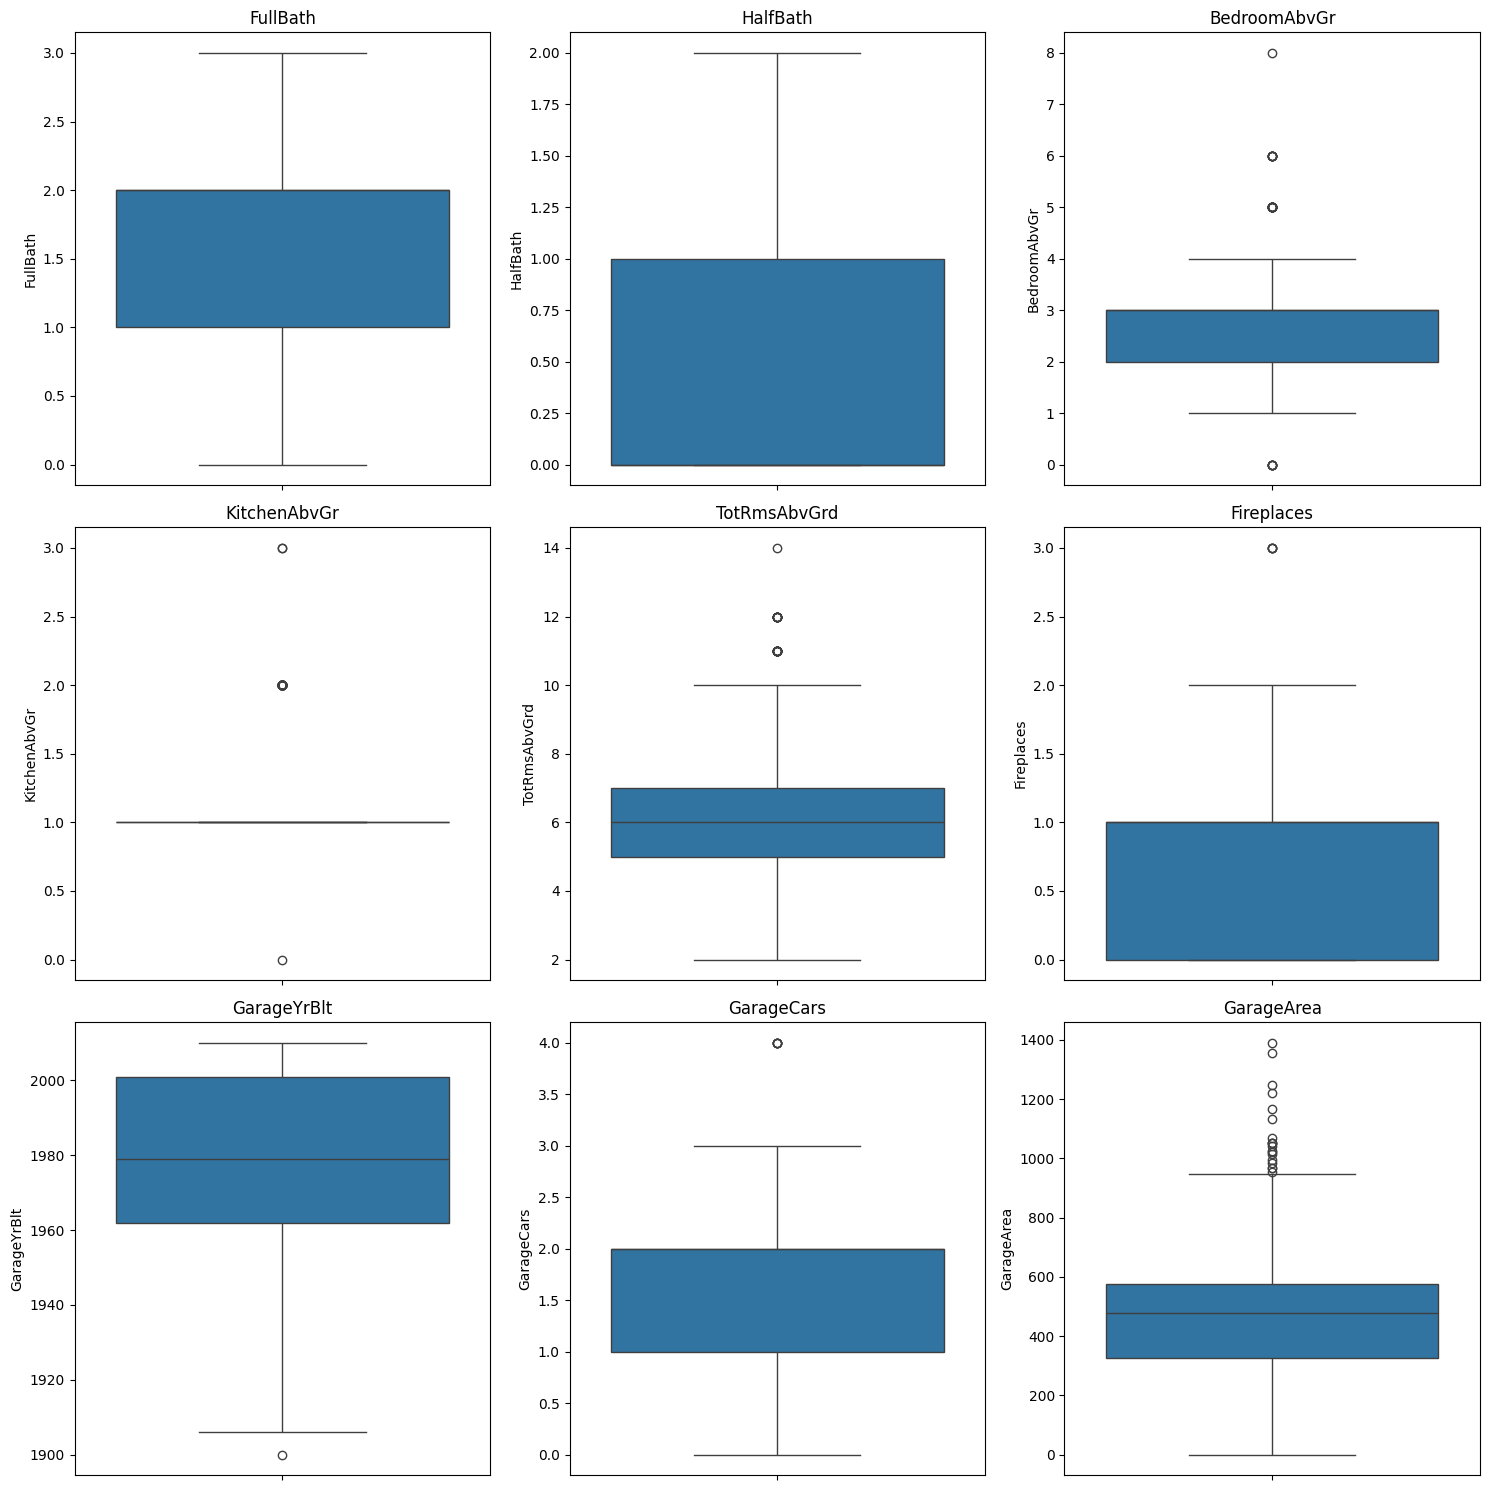

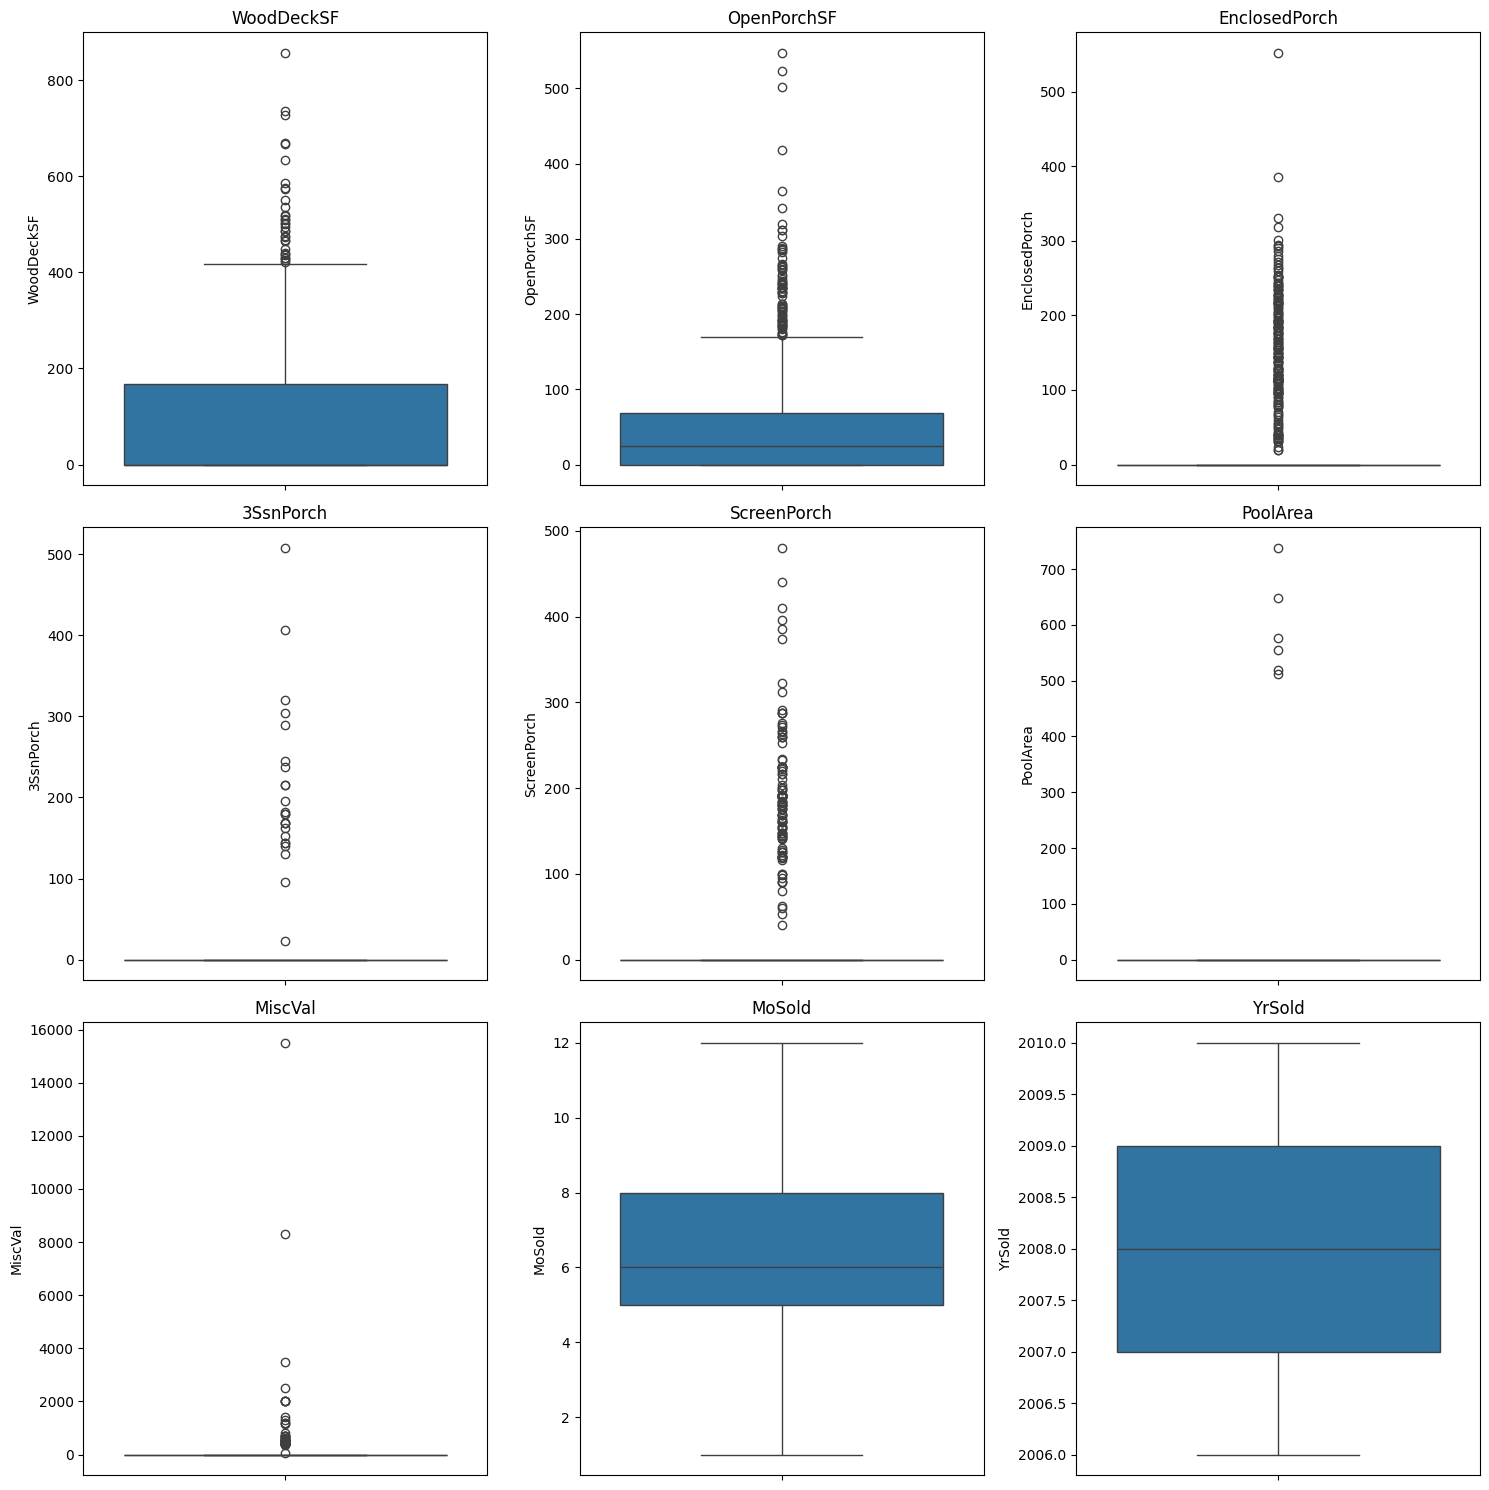

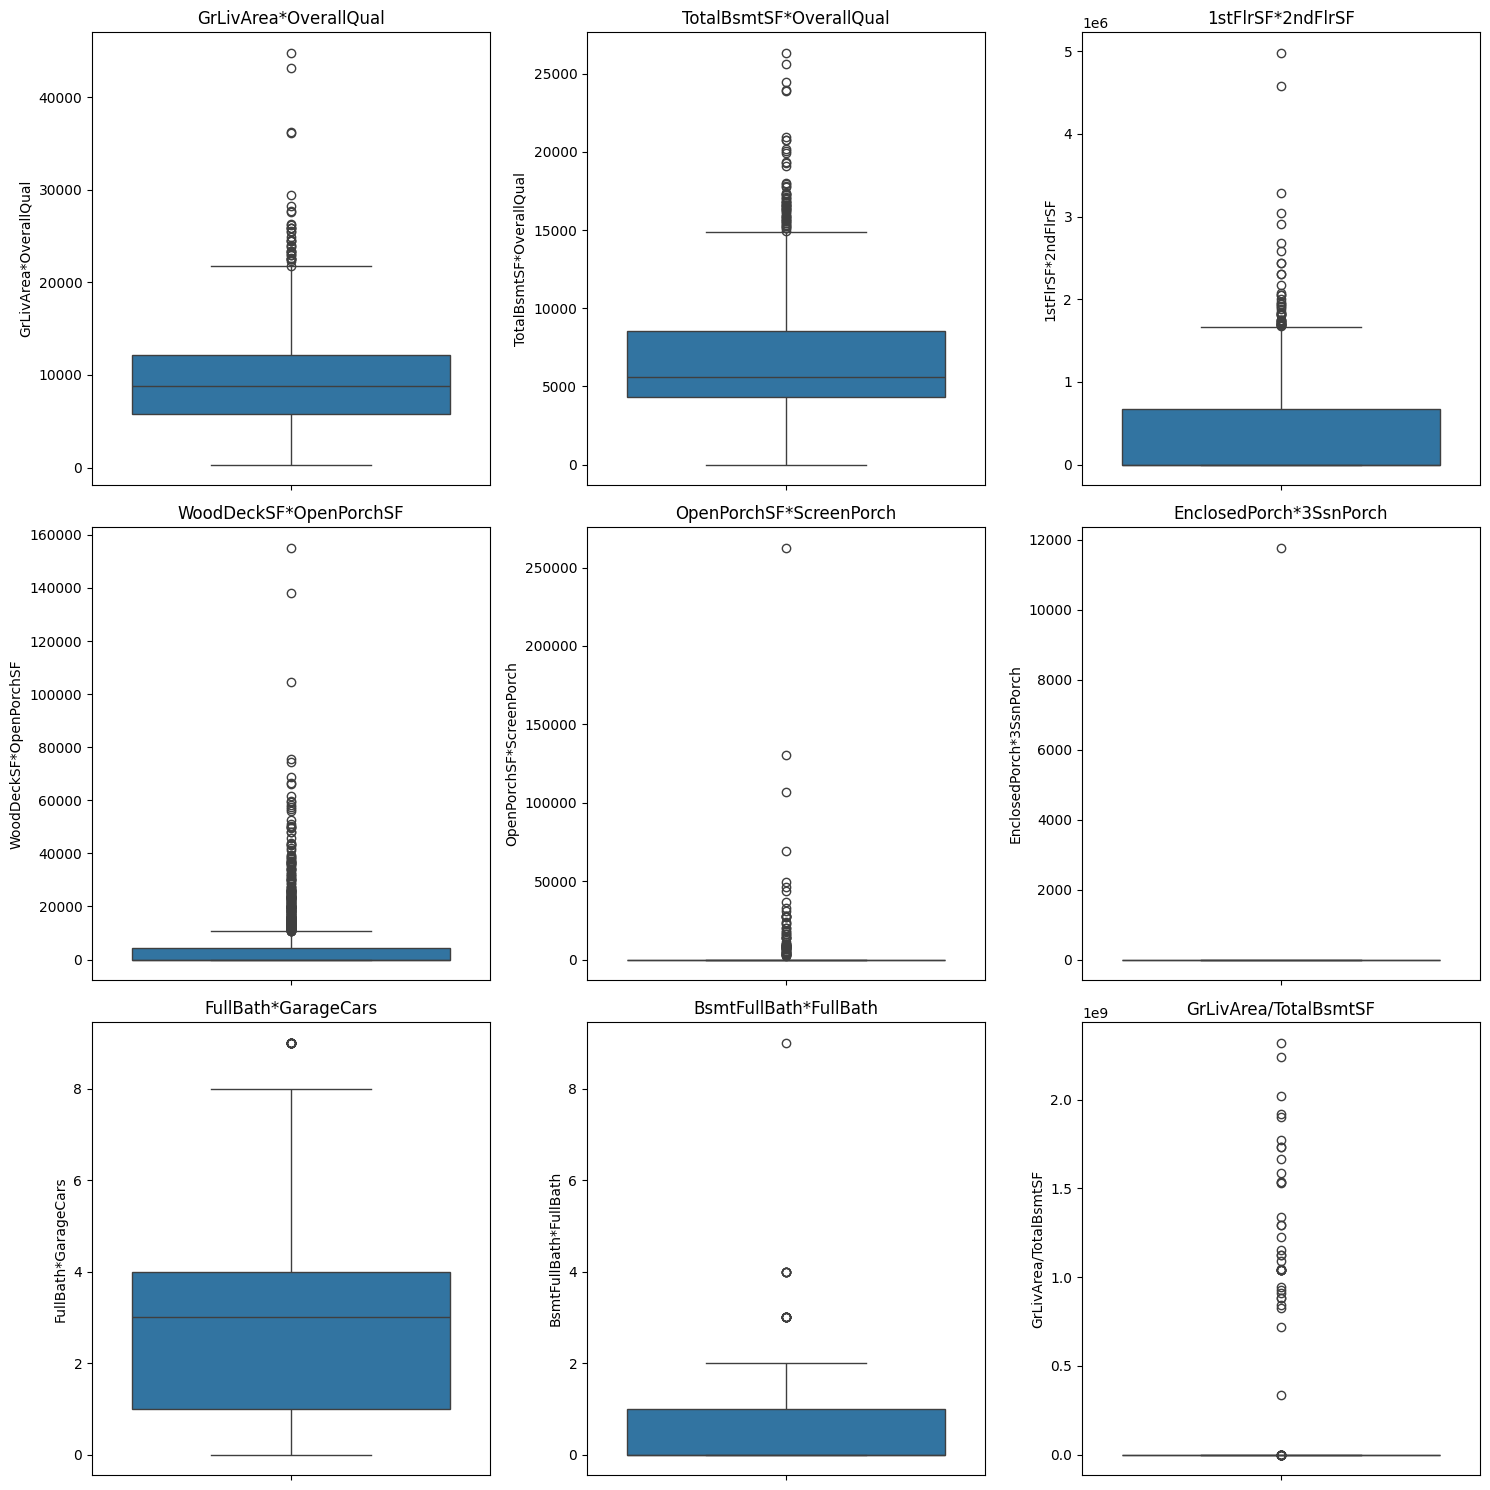

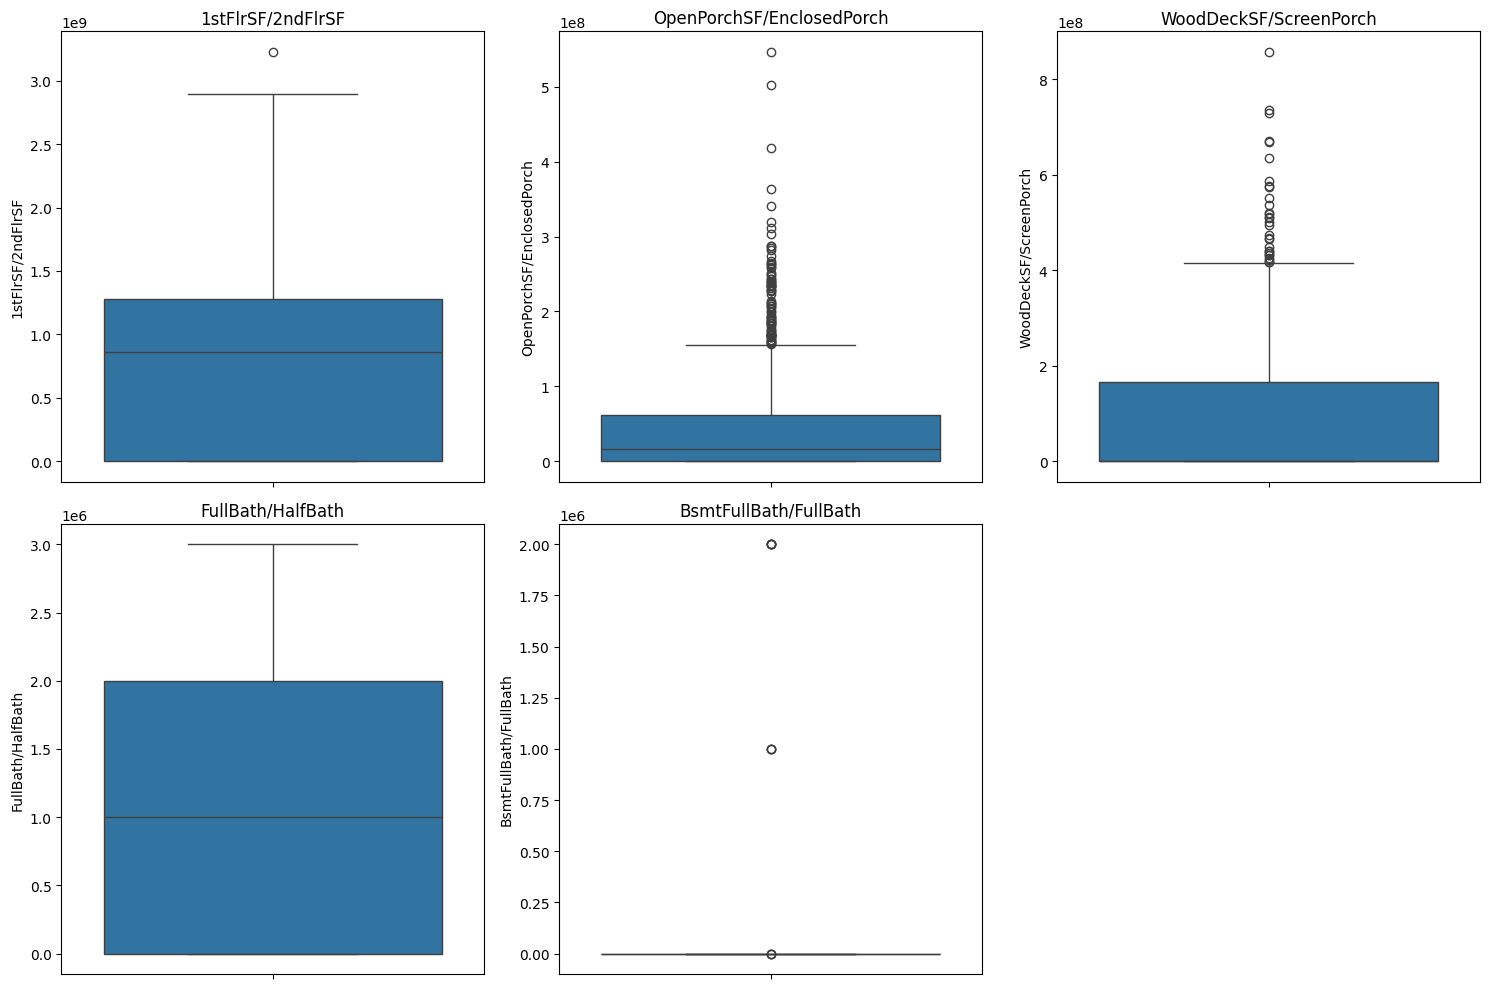

In [231]:
hp.plot_boxplots(X_interac)

In [232]:

product_labels = [f"{a}*{b}" for a, b in product_tuples]
ratio_labels = [f"{a}/{b}" for a, b in ratio_tuples]

cols_log_interac = cols_log_all+ ['GrLivArea*OverallQual', 'TotalBsmtSF*OverallQual', '1stFlrSF*2ndFlrSF', 'WoodDeckSF*OpenPorchSF', 'OpenPorchSF*ScreenPorch','EnclosedPorch*3SsnPorch', 'BsmtFullBath*FullBath' , 'GrLivArea/TotalBsmtSF',
                                  'OpenPorchSF/EnclosedPorch', "WoodDeckSF/ScreenPorch"]
num_cols_interac = num_cols_all + product_labels + ratio_labels

print('################ Evaluating new features with interactions #####################\n')

alphas =[0.001, 0.01, 1 , 10, 50, 100]

for alpha in alphas:
  print(f'alpha = {alpha}')
  h.evaluate_all_linear(X_interac ,y, numeric_columns=num_cols_interac, categorical_columns=cat_cols_all,
                      log_columns=cols_log_interac, alpha=alpha)
  print()

################ Evaluating new features with interactions #####################

alpha = 0.001
Linear:           MAE: 14675.690607475373 | RMSLE: 0.12151490821242932
Lasso:            MAE: 14161.077786601289 | RMSLE: 0.11654477916282263
Ridge:            MAE: 14675.347265440138 | RMSLE: 0.12151490821242932
elastic_net:      MAE: 14094.1611195733 | RMSLE: 0.12151490821242932

alpha = 0.01
Linear:           MAE: 14675.690607475373 | RMSLE: 0.12151490821242932
Lasso:            MAE: 16935.09878023985 | RMSLE: 0.13161991627256975
Ridge:            MAE: 14672.316528777892 | RMSLE: 0.12151490821242932
elastic_net:      MAE: 16009.622850793327 | RMSLE: 0.12151490821242932

alpha = 1
Linear:           MAE: 14675.690607475373 | RMSLE: 0.12151490821242932
Lasso:            MAE: 55518.75352654699 | RMSLE: 0.3995084641635143
Ridge:            MAE: 14532.519676362821 | RMSLE: 0.12151490821242932
elastic_net:      MAE: 55518.75352654699 | RMSLE: 0.12151490821242932

alpha = 10
Linear:           MAE

We can use a Lasso model to make feature selection.

In [233]:
lasso = h.create_lasso_pipeline(
                              numeric_columns=num_cols_interac,
                              categorical_columns=cat_cols_all,
                              log_columns=cols_log_interac,
                              alpha=0.001)
results , lasso = h.evaluate_model(X_interac, y, lasso, return_trained_model=True)
print(results)

{'mae': 14161.077786601289, 'rmsle': np.float64(0.11654477916282263)}


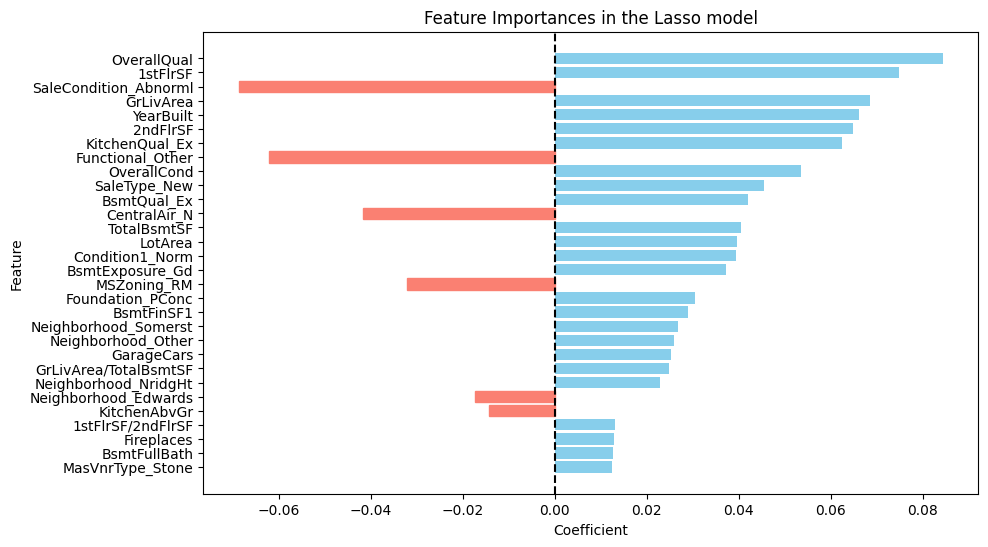

In [234]:
lasso_coef = h.get_coef_signed(lasso)
h.plot_coeficients_importance(lasso_coef, top_n=30, title="Feature Importances in the Lasso model")

In [235]:
lasso_coef
lasso_coef_pos = lasso_coef[(lasso_coef.coefficient != 0) ]

#Get categorical an numerical features filtering with Lasso
cat_cols_select = list(set([col.split("_")[0] for col in lasso_coef_pos.feature if len(col.split("_"))>1]))
num_cols_select = [col for col in lasso_coef_pos.feature if col in num_cols_interac]
cols_log_select = [col for col in lasso_coef_pos.feature if col in cols_log_interac]

cols_select = num_cols_select + cat_cols_select


product_labels_select = [label for label in product_labels if label in num_cols_select]
ratio_labels_select = [label for label in ratio_labels if label in num_cols_select]

product_tuples_select= [(product.split('*')[0], product.split('*')[1] ) for product in product_labels_select]
ratio_tuples_select = [(ratio.split('*')[0], ratio.split('/')[1] ) for ratio in ratio_labels_select]

print('Number of columns before filtring:', X_interac.shape[1])
print('Number of columns after filtring:', len(cols_select))
print('Columns removed: ', [ col for col in X_interac.columns if col not in cols_select] )
print('Products considered: ', product_labels_select )
print('Ratios considered: ', ratio_labels_select )


Number of columns before filtring: 87
Number of columns after filtring: 61
Columns removed:  ['LotShape', 'LandContour', 'LandSlope', 'Condition2', 'BldgType', 'HouseStyle', 'RoofMatl', 'MasVnrArea', 'ExterQual', 'BsmtFinType2', 'Heating', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'TotRmsAbvGrd', 'GarageQual', 'GarageCond', 'OpenPorchSF', 'GrLivArea*OverallQual', 'TotalBsmtSF*OverallQual', '1stFlrSF*2ndFlrSF', 'OpenPorchSF*ScreenPorch', 'FullBath*GarageCars', 'WoodDeckSF/ScreenPorch', 'FullBath/HalfBath', 'BsmtFullBath/FullBath']
Products considered:  ['WoodDeckSF*OpenPorchSF', 'EnclosedPorch*3SsnPorch', 'BsmtFullBath*FullBath']
Ratios considered:  ['GrLivArea/TotalBsmtSF', '1stFlrSF/2ndFlrSF', 'OpenPorchSF/EnclosedPorch']


We note that after filtering columns using a Lasso model we get 61 features. Lets see how our models perform with these features.

In [236]:
alphas =[0.001, 0.01, 1 , 10, 50, 100]

for alpha in alphas:
  print(f'alpha = {alpha}')
  h.evaluate_all_linear(X_interac[cols_select] ,y, numeric_columns=num_cols_select, categorical_columns=cat_cols_select,
                      log_columns=cols_log_select, alpha=alpha)
  print()

alpha = 0.001
Linear:           MAE: 14278.58753387233 | RMSLE: 0.11818088886314658
Lasso:            MAE: 14089.293720629785 | RMSLE: 0.11586797800132612
Ridge:            MAE: 14278.38894291293 | RMSLE: 0.11818088886314658
elastic_net:      MAE: 13956.951043299552 | RMSLE: 0.11818088886314658

alpha = 0.01
Linear:           MAE: 14278.58753387233 | RMSLE: 0.11818088886314658
Lasso:            MAE: 16968.963512414623 | RMSLE: 0.13160226424674384
Ridge:            MAE: 14276.621806566302 | RMSLE: 0.11818088886314658
elastic_net:      MAE: 16021.583450579734 | RMSLE: 0.11818088886314658

alpha = 1
Linear:           MAE: 14278.58753387233 | RMSLE: 0.11818088886314658
Lasso:            MAE: 55518.75352654699 | RMSLE: 0.3995084641635143
Ridge:            MAE: 14179.441532446312 | RMSLE: 0.11818088886314658
elastic_net:      MAE: 55518.75352654699 | RMSLE: 0.11818088886314658

alpha = 10
Linear:           MAE: 14278.58753387233 | RMSLE: 0.11818088886314658
Lasso:            MAE: 55518.75352

We note that after adding interactions and filttering  with Lasso coeficients, most of the models show better performance. In particular, the best model so far is Lasso with feature selecting and interactions, and alpha=0.001 which has a `rmsle=0.11586797800132612`. Let's define this pipeline including the interactions.

In [237]:
lasso = h.create_lasso_pipeline(
    numeric_columns=num_cols_select,
    categorical_columns=cat_cols_select,
    log_columns=cols_log_select,
    alpha=0.001
)

result , best_lasso = h.evaluate_model(X_interac[cols_select], y, model = lasso)
result

{'mae': 14089.293720629785, 'rmsle': np.float64(0.11586797800132612)}

In [238]:
### Function to preprocess the data before use the pipeline
def lasso_process(X):
  X_interac, _= h.add_interactions(X, product_tuples=product_tuples, ratio_tuples=ratio_tuples)
  return X_interac[cols_select]

## XGBoost model
Now let's train an XGBoost model baseline. We use X_label which alredy encoded the categorical feature.

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.05,
    max_depth=10,            # Max depth of each tree
    subsample=0.8,          # Percentage of data per tree
    colsample_bytree=0.8,   # Percentage of features per tree
    random_state=0
)

print(h.evaluate_model(X_label,y, xgb_model))


We see that XGBoost model performs worst, than the linear models.

#CONCLUSIONS AND FURTHER STRATEGIES

Our analysis shows that regularized linear regression models can provide strong predictive performance for the housing prices dataset. We also observed that RMSLE may vary between local validation and the competition leaderboard, underlining the importance of careful validation. By applying feature selection and creating new features, we achieved measurable improvements in linear models.
For future work, we plan to integrate well-tuned tree-based models such as XGBoost to further enhance performance. In addition, experimenting with new feature combinations and advanced feature selection methods (such as mutual information or feature importance from XGBoost) could bring further gains.
